# In-class exercise 3: Backscattering Coefficients
In this notebook, we will introduce some of the steps involved in the processing of Sentinel-1 Level1 Ground Range Detected (`GRD`) data to $\sigma^0$ (`sig0`) and $\gamma^0$ (`gmr`). Moreover, the notebook illustrates the importance and impact of geometric and radiometric terrain correction. As the processing of SAR data is a very time and hardware-intense task, we won't perform the actual processing in this notebook. Instead, data at different processing steps is illustrated to highlight the impact of the processing steps.

In [1]:
import numpy as np
import xarray as xr
import rioxarray #noqa
import matplotlib.pyplot as plt # noqa
import hvplot.xarray  # noqa

from pathlib import Path
from functools import partial

## Loading Backscatter Data

We first load our data with `xarray`, select an area of interest, and scale the variables if necessary. For this, we use the following preprocessing function. 

In [2]:
def _preprocess(x, xlims, ylims, scale):
    '''
    Preprocess file.

    Parameters
    ----------
    x : xarray.Dataset
    xlims: tuple
    ylims: tuple

    Returns
    -------
    xarray.Dataset
    '''
    x = x * scale
    x = x.sel(x=slice(*xlims), y=slice(*ylims))
    x = x.assign_coords(band=[Path(x.encoding["source"]).parent.stem])
    return x

The data is located on the `shared` folder of your home directory and can be loaded and preprocessed, as follows.

In [3]:
data_path = Path("~/shared/datasets/rs/sentinel-1").expanduser()

xlims, ylims = (9.5, 10), (47.5, 47)
partial_func = partial(_preprocess, xlims=xlims, ylims=ylims, scale=1)

gtc_dc = xr.open_mfdataset(
    (data_path / "gtc").glob("**/*.tif"),
    engine="rasterio",
    combine="nested",
    concat_dim="band",
    preprocess=partial_func,
    join="override",
    parallel=True
    ).\
    compute()

gtc_dc

<xarray.Dataset> Size: 116MB
Dimensions:      (band: 2, y: 3800, x: 3801)
Coordinates:
  * x            (x) float64 30kB 9.5 9.5 9.5 9.5 9.501 ... 10.0 10.0 10.0 10.0
  * y            (y) float64 30kB 47.5 47.5 47.5 47.5 ... 47.0 47.0 47.0 47.0
    spatial_ref  int64 8B 0
  * band         (band) <U8 64B 'grd' 'sig0_gtc'
Data variables:
    band_data    (band, y, x) float32 116MB 151.0 119.0 119.0 ... nan nan nan

## Geometric terrain correction

Level 1 SAR data, such as the “GRD” product only takes into account the ellipsoidal model of the earth (i.e. slant-range distortion; script Chapter 4), without the description of the relief. This makes mountains appear to lean towards the radar system as visible in the below plot of the GRD scene. This latter distortion originates from the side-looking geometry of the SAR system. Due to this, the radar pulse reaches mountain slope facing the sensor before it reaches the base. Consequently, these slopes appear compressed and leaning toward the sensor. During processing to a level 1C product, these slant range distortions are partly corrected using a terrain correction algorithm and a Digital Elevation Model (DEM). The most common algorithm for this is the Range Doppler Terrain Correction.

![](https://www.esri.com/arcgis-blog/wp-content/uploads/2024/05/emenezes-esriBlog-GP-tool-fig_Apply-Geometric-Terrain-Correction-detailed.png)
*Figure 1: Illustration of the ground range with and without geometric terrain correction (Source: ESRI)*.

Figure 1 illustrates this correction step. The lower bar shows the GRD without geometric terrain correction  in slant geometry. In areas where the ground is elevated, the time of the signal to travel to the earth’s surface and back to the sensor is distorted, causing geometric shifts (foreshortening, lengthening, etc). Using a DEM and the Range Doppler Terrain Correction, the distortions are corrected and the image is orthorectified.

Let's visualize this geometric terrain correction (GTC) with some actual data using the `xarray` method `hvplot` of the `gtc_dc` object.

In [4]:
gtc_dc.hvplot.image(x="x", y="y", robust=True, data_aspect=1, cmap="Greys_r",
                    groupby="band", rasterize=True).\
                        opts(frame_height=600, framewise=False)

:DynamicMap   [band]
   :Image   [x,y]   (band_data)

*Figure 2: The ground range detected values and geometrically terrain corrected values can be selected on the right-hand side of the graphic.*

The geometrically terrain corrected values from the `gtc_dc` object (Figure 1) can be approximated to a certain extent, as we have sufficiently detailed information of topography in this area. This corrects for at least one typically occurring distortion in mountainous regions: "foreshortening".

![](../assets/images/side_looking_image_distortions.png)

*Figure 3: Side Looking radar distortions (script Chapter 4).*

Foreshortening can be spotted by eye, as it often has a radiometric consequence, where unusually bright areas fringe mountain ridges; a phenomenon called "highlighting". This geometric artifact occurs due to the compression of the distance in the image of slopes facing the radar system and the consequentially higher density of scatterers per unit length. Now let's zoom in on an example from the same data cube and display the original and corrected values side-by-side.

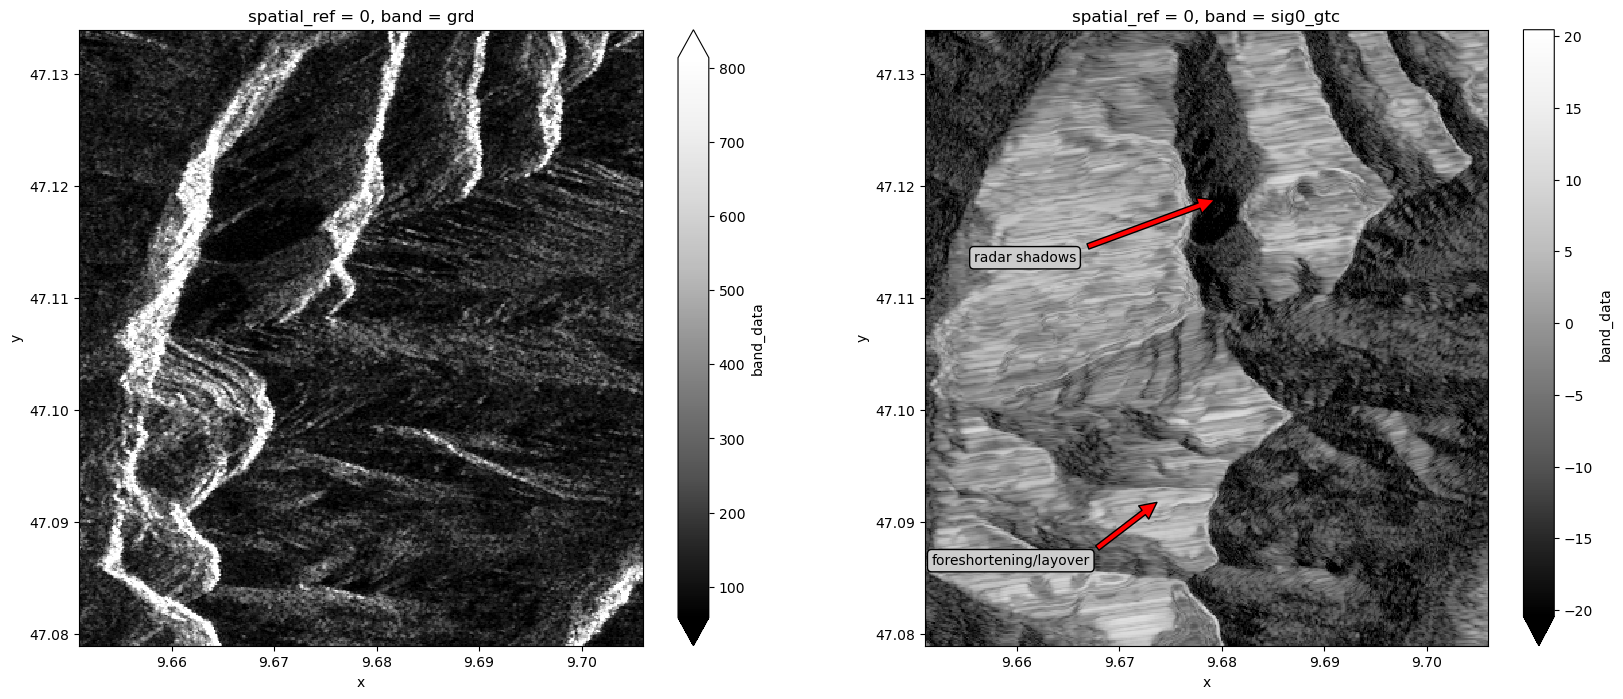

In [5]:
for_dc = gtc_dc.sel(x=slice(9.651, 9.706), y=slice(47.134, 47.079)). \
    band_data

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

bbox = dict(boxstyle="round", fc="0.8")


ax[1].annotate(
    "foreshortening/layover",
    xy=(9.674, 47.092),
    xytext=(0.574, 0.192),
    textcoords='subfigure fraction',
    bbox=bbox,
    arrowprops=dict(facecolor='red', shrink=0.05),
    )
ax[1].annotate(
    "radar shadows",
    xy=(9.68, 47.119),
    xytext=(0.6, 0.625),
    textcoords='subfigure fraction',
    bbox=bbox,
    arrowprops=dict(facecolor='red', shrink=0.05),
    )

for_dc.sel(band="grd").plot(ax=ax[0], robust=True, cmap="Greys_r")
for_dc.sel(band="sig0_gtc").plot(ax=ax[1], robust=True, cmap="Greys_r")

*Figure 4: Close-up inspection of geometric distortions in side-looking radar*

As we can see, not all the geometric distortions can be corrected by the algorithm. Some of the pixels at the mountain ranges appear stretched, as in these areas not enough valid measurements are available. Moreover, we can see dark areas which are indicating radar shadows. These are image areas that could not be captured by the radar sensor and have values close to the noise floor of the Sensor (minimum detectable signal strength) ~ -28dB. It is important to note, that radar shadows are not the same for every image, as they depend on the acquisition geometry, in particular, the incidence angle and the flight direction of the satellite.

## Backscattering Coefficients

In this chapter, we will look at some of the different backscatter coefficients in more detail ($\sigma^0_E$ or $\gamma^0_E$), where both coefficients are geometrically terrain corrected. The difference is the plane of the reference area, which is the ground area as a tangent on an ellipsoidal Earth model for $\sigma^0_E$ and perpendicular to the line of sight for $\gamma^0_E$ (Figure 5). For this, we load a new data cube which includes $\sigma^0_E$ and the Incidence Angle for each pixel. We visualize the cube with the same method as before.

In [9]:
xlims, ylims = (9.5, 10), (47.5, 47)
partial_func = partial(_preprocess, xlims=xlims, ylims=ylims, scale=1)

coef_dc = xr.open_mfdataset(
    (data_path / "coefs").glob("**/*.tif"),
    engine="rasterio",
    combine="nested",
    concat_dim="band",
    preprocess=partial_func,
    join="override",
    parallel=True
    ).\
    compute()

coef_dc.hvplot.image(x="x", y="y", robust=True, data_aspect=1, cmap="Greys_r",
                     groupby="band", rasterize=True).\
                        opts(frame_height=600, framewise=False)

:DynamicMap   [band]
   :Image   [x,y]   (band_data)

*Figure 5: The $\sigma^0_E$ and the incidence angle can be selected on the right-hand side of the graphic.*

In Figure 5 we can see the incidence angle image of our scene. We can see, that it depicts the differences between near to far range, but not the actual terrain as it refers to the ellipsoid. The slight patterns of the terrain that are visible are originating from the   We will use this information now to convert our ($\sigma^0_E$ to $\gamma^0_E$) with the following equation (equation 6.20 in the script):

$$ \gamma^0_E = \sigma^0_E / \cos(\theta_i) $$

We can perform this transformation with basic `numpy` operations on the `xarray` datacube.

In [7]:
# linear scale
sig0_db = (coef_dc.sel(band="sig0_gtc") / 10)
sig0_lin = 10 ** (coef_dc.sel(band="sig0_gtc") / 10)
# conversion to gamma
gam0_lin = sig0_lin / np.cos(np.radians(coef_dc.sel(band="incidence_angle")))
# dB scale
gam0_db = 10 * np.log(gam0_lin)
# add to existing cube
coef_dc = xr.concat(
    [coef_dc.sel(band="sig0_gtc"), gam0_db.expand_dims(band=["gam0_gtc"])],
    dim="band"
    )

coef_dc.hvplot.image(x="x", y="y", robust=False, data_aspect=1, cmap="Greys_r",
                     groupby="band", rasterize=True).\
                        opts(frame_height=600, framewise=False)

:DynamicMap   [band]
   :Image   [x,y]   (band_data)

*Figure 6: $\sigma^0_E$, and $\gamma^0_E$ can be selected on the right-hand side of the graphic.*

Comparing $\sigma^0_E$ and $\gamma^0_E$ in the figure, we can see that both look identical except for the range. This is because the only difference between $\sigma^0_E$ and $\gamma^0_E$ is the change of the reference area. While $\sigma^0_E$ is defined to be ground range, $\gamma^0_E$ is defined to be in the plane perpendicular to the line of sight from the sensor. This way, $\gamma^0_E$ mitigates the impact of the incidence angle. However, $\gamma^0_E$ is still based on the ellipsoid and does not account for the impact of the terrain on the radiometry.

# Radiometric Terrain Correction

So far, we corrected geometric distortions and compared the impact of the choice of the reference area. However, we still haven't corrected the backscatter intensity of pixels which are distorted by the terrain. In this last step, we will show that we can also correct radiometric artifacts to a certain degree. For this, we will load radiometrically terrain corrected (`rtc`) $\gamma^0_T$ and plot it along the other coefficients.


In [8]:
xlims, ylims = (9.5, 10), (47.5, 47)
partial_func = partial(_preprocess, xlims=xlims, ylims=ylims, scale=1)

rtc_dc = xr.open_mfdataset(
    (data_path / "rtc").glob("**/*.tif"),
    engine="rasterio",
    combine="nested",
    concat_dim="band",
    preprocess=partial_func,
    join="override",
    parallel=True
    ).\
    compute()

# add to existing cube
rtc_dc = xr.concat([coef_dc, rtc_dc], dim="band")

rtc_dc.hvplot.image(x="x", y="y", robust=True, data_aspect=1, cmap="Greys_r",
                    groupby="band", rasterize=True).\
                        opts(frame_height=600, framewise=False)

:DynamicMap   [band]
   :Image   [x,y]   (band_data)

When comparing $\gamma^0_E$ and $\gamma^0_T$ in the plot we can clearly see the impact of the radiometric correction in the mountainous areas. This correction is necessary, because for slopes facing towards the sensor, a larger ground area contributes to the backscatter value of a slant range resolution cell, than for slopes lying in the opposite direction. This results in significant brightness changes, where foreshortening areas appear brighter and lengthening areas darker. $\gamma^0_T$ adjusts the backscatter to represent what it would be if the terrain was flat, thus reducing these effects. This significantly reduces the impact of the terrain on the backscatter values, allowing for more accurate comparisons across different terrain types and locations. The correction is done by using a DEM to determine the local illuminated area at each radar position (Figure 5). The above illustrated approach is also referred to as terrain flattening because in the resulting image, mountains appear flat. As $\gamma^0_T$ is corrected for geometric and radiometric distortions, it is also referred to as Normalized Radar Backscatter (NRB) and is the current standard for Analysis-Ready-Backscatter (ARD).